Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [25]:
import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [19]:
dowjones_closing = dowjones_closing['Close'].values

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [70]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


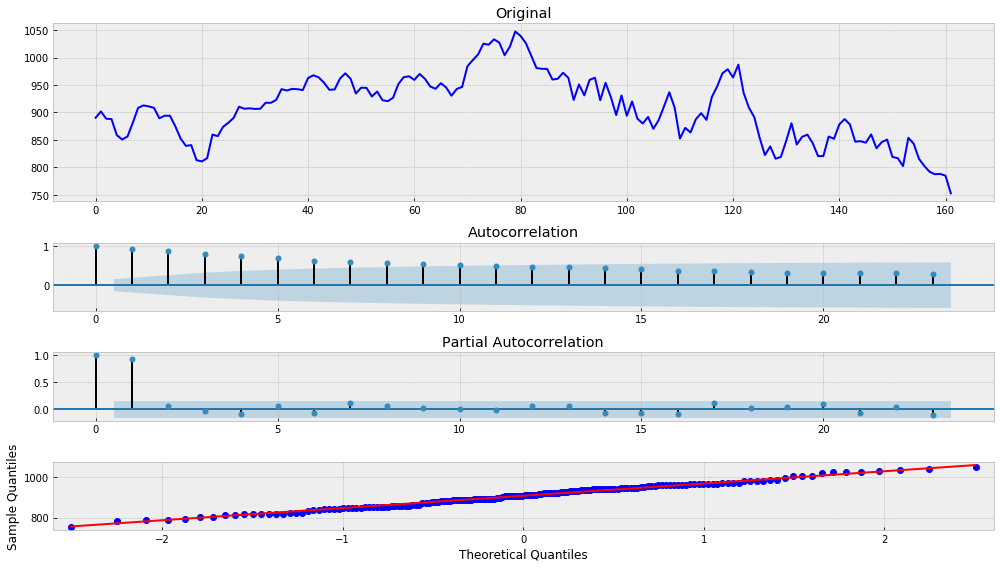

In [20]:
tsplot(dowjones_closing)

aic: 1416.27670 | order: (2, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                -1.184570e+01
p-value                        7.408465e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


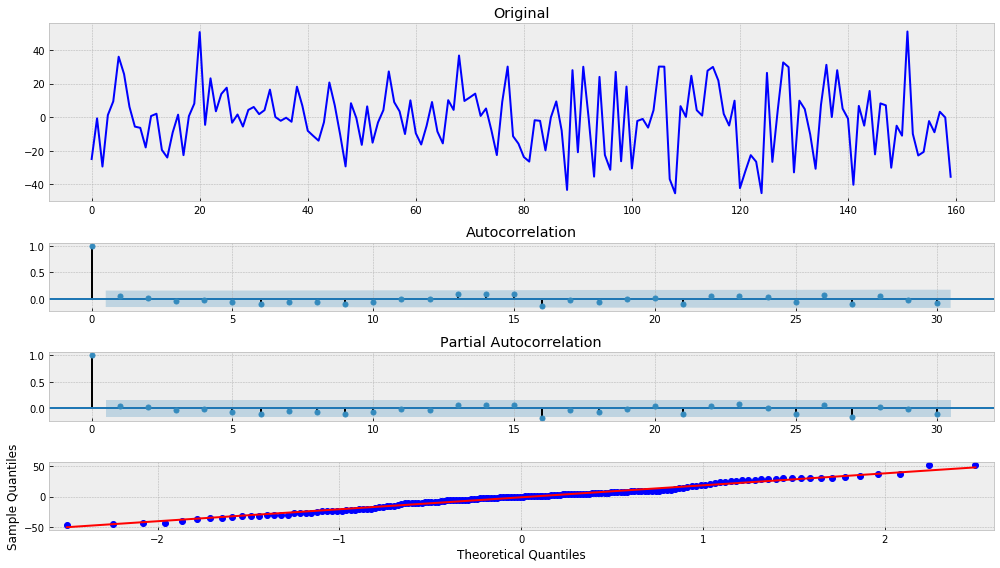

In [26]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(dowjones_closing, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [71]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [ ]:
series = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [85]:
series_pred = predict(pd.Series(best_mdl.resid), 7, 50)

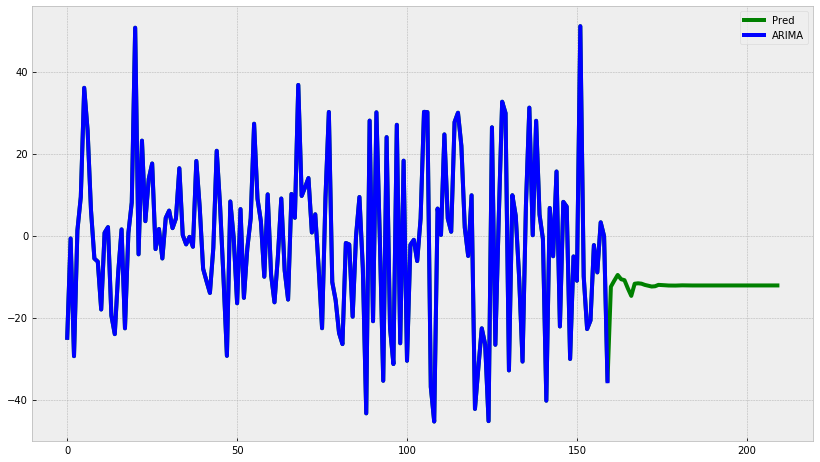

In [87]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(pd.Series(best_mdl.resid), color='blue', linewidth='4', label='ARIMA')
    plt.legend()

In [88]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

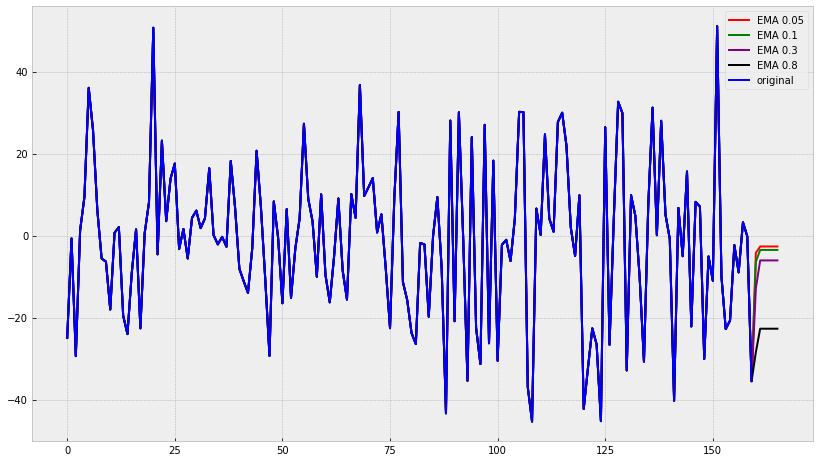

In [91]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(pd.Series(best_mdl.resid), alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(pd.Series(best_mdl.resid), color='blue',label='original')
    plt.legend()

In [28]:
!pip install arch

     |████████████████████████████████| 783 kB 1.4 MB/s eta 0:00:01


In [29]:
from arch import arch_model

In [55]:
p_ = 2
o_ = 0
q_ = 3

series = boxcox(dowjones_closing, 0)
series = np.diff(series, 1)

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.005
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.005
Vol Model:                            GARCH   Log-Likelihood:                393.473
Distribution:      Standardized Student's t   AIC:                          -770.946
Method:                  Maximum Likelihood   BIC:                          -746.295
                                              No. Observations:                  161
Date:                      Sun, Nov 29 2020   Df Residuals:                      153
Time:                              12:40:09   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


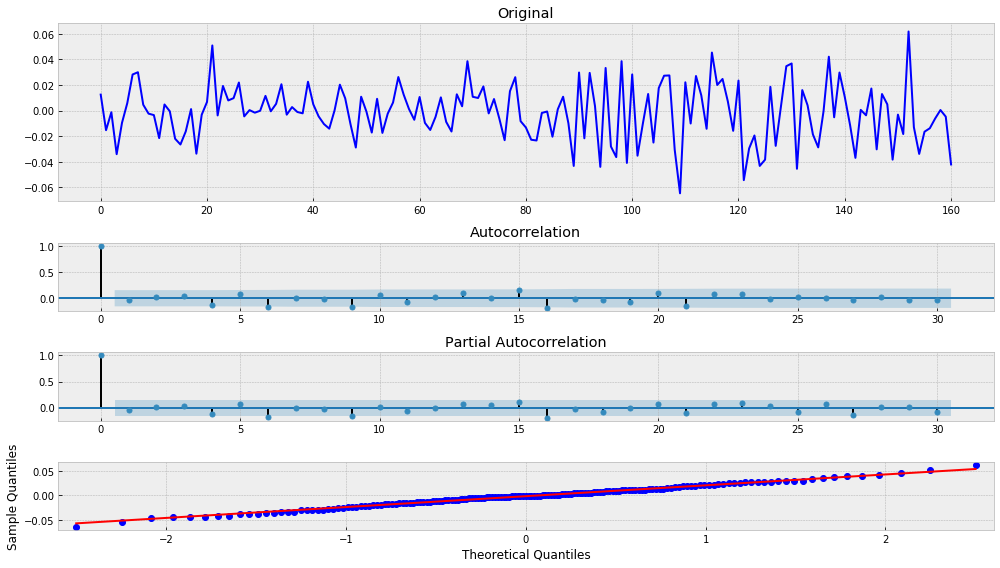

In [56]:
tsplot(res.resid, lags=30)

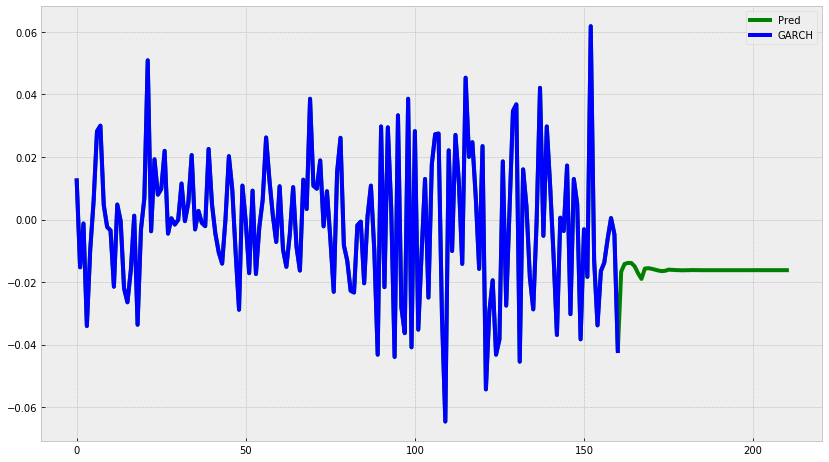

In [95]:
series_pred = predict(pd.Series(res.resid), 7, 50)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(pd.Series(res.resid), color='blue', linewidth='4', label='GARCH')
    plt.legend()

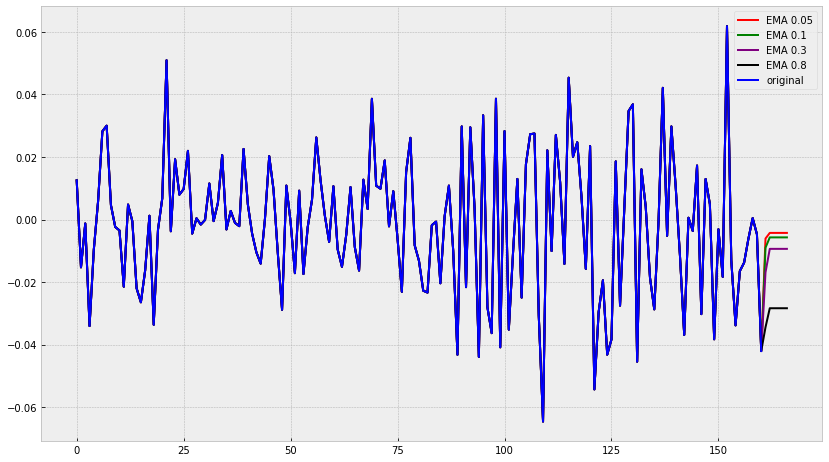

In [97]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(pd.Series(res.resid), alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(pd.Series(res.resid), color='blue',label='original')
    plt.legend()

По тестам модель ARIMA лучше смоделировала исходный ряд, чем GARCH. 

Cпрогнозировать график классическим ML. 

In [65]:
series = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [66]:
series

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43
...,...,...
157,1974-W28,791.77
158,1974-W29,787.23
159,1974-W30,787.94
160,1974-W31,784.57


In [67]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [68]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

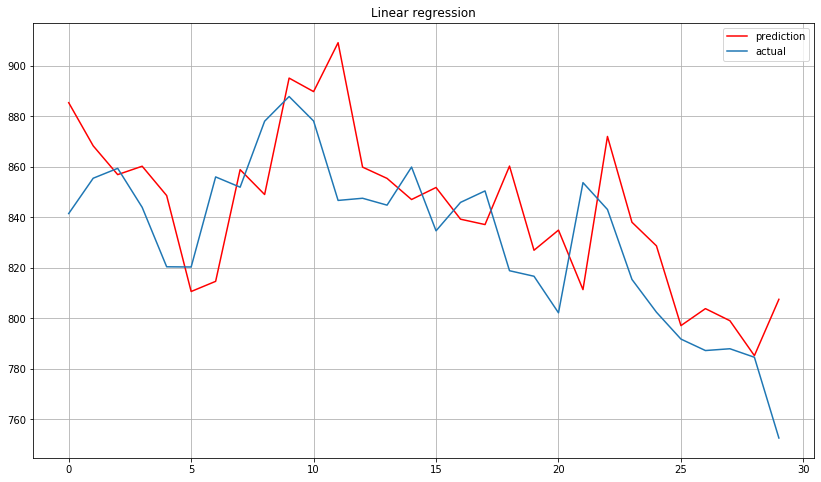

In [69]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);